# Acerca de este Notebook

Este documento presenta un análisis integral dividido en dos vertientes principales: 

**La resolución de un problema de negocio para la aseguradora `Sure Tomorrow` mediante aprendizaje supervisado y una demostración metodológica de álgebra lineal aplicada a la privacidad de datos.**

1. Análisis Exploratorio `(EDA)` y `Clasificación BinariaEn` esta sección, aborda la predicción de la probabilidad de que un cliente reciba beneficios de seguro, siguiendo las etapas críticas de un proyecto de ciencia de datos:

    - Exploración y Diagnóstico: Se analizan las correlaciones mediante pairplots y se examina la distribución de la variable continua income (ingresos), identificando sesgos y valores atípicos.
    - Validación de Agrupación (Clustering): Se valida la lógica del etiquetado de los planes de seguro (rango [0,5]) mediante el algoritmo de `K-Nearest Neighbors` (KNN). El objetivo es confirmar que la asignación de planes es consistente con el perfil de clientes similares según su distancia euclidiana.
   - Modelado Predictivo: Se transforma el problema en una clasificación binaria (¿Obtendrá seguro?: Sí/No). Se gestiona el desbalance de clases mediante particiones estratificadas usando `train_test_split` `scikit-learn`.
   - Se establecen modelos dummy con diversos umbrales de probabilidad para definir una línea base de rendimiento (baseline).
   - Se optimiza un modelo `KNeighborsClassifier`, identificando el número de vecinos ideal ($n=3$) y comparando el desempeño entre datos crudos y escalados.
   - **Resultados:** El modelo final, entrenado con datos escalados, alcanzó métricas de alto rendimiento: F1: `95.21%`, Precisión: `96.36%` y Recall: `94.08%`.

2. Álgebra Lineal: Regresión y Ofuscación de Datos: Esta sección posee un enfoque pedagógico y metodológico, diseñado para demostrar la robustez de los algoritmos lineales frente a transformaciones matriciales.

    - Implementación desde Cero: Se desarrolla un algoritmo de Regresión Lineal basado en la solución analítica de la ecuación matricial. $$\hat{y} = Xw$$
    - Invarianza del Escalamiento: Se demuestra empíricamente que el escalado de datos no altera la capacidad predictiva del modelo de regresión, manteniendo la consistencia en el Error Cuadrático Medio (MSE).
    - Protección de la Privacidad (Ofuscación): Se propone y demuestra un método de encriptación de datos multiplicando la matriz de características $X$ por una matriz invertible $P$.
    - Prueba Analítica: Se incluye la demostración matemática que comprueba por qué los valores predichos $$\hat{y}$$ permanecen idénticos incluso cuando los datos están ofuscados, garantizando la utilidad del modelo sin vulnerar la privacidad de la información original.

Nota Metodológica: Pipeline del Proyecto
---
Este notebook implementa un flujo de trabajo de Aprendizaje Semi-supervisado, estructurado en tres fases críticas para garantizar la robustez del modelo predictivo:

Segmentación (Clustering): Identificación de patrones ocultos y generación de etiquetas de grupos basadas en el comportamiento y perfil del cliente. (`Esta fase no esta incluida en este notebook. El clustering se hizo previamente`).

Auditoría de Calidad (Validación de Vecindad): Evaluación de la consistencia de los grupos mediante la Métrica de Integridad (KNN). Esto asegura que la segmentación no sea "ruido", verificando que los clientes agrupados compartan características espaciales sólidas antes de proceder al modelado.

Automatización (Clasificación): Entrenamiento de un modelo supervisado (KNeighborsClassifier) sobre un conjunto de datos validado. Este modelo final permite automatizar la toma de decisiones para nuevos clientes con un alto nivel de confianza y explicabilidad.

- O sea: `Clustering` -> `Validacion de Clustering` -> `Modelo`

Proyecto Contexto:
---
La compañía de seguros `Sure Tomorrow` quiere resolver varias tareas con la ayuda de Machine Learning y te pide que evalúes esa posibilidad.

- Tarea 1: Encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: Predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: Proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning.

# Carga de Datos y Descripción

In [1]:
# Librrias

# Data Wrangling:
import numpy as np
import pandas as pd

# Maths
import math

# Visualizacion
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Machine Learning Tools
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

from IPython.display import display


SEED = 12345

In [2]:
df = pd.read_csv('C:/Users/GaloA/Documents/ciencia_de_datos/insurance/insurance_us.csv')
# Renombrar Columnas
df = df.rename(columns={
    'Gender':'gender',
    'Age':'age',
    'Salary':'income',
    'Family members':'family_members',
    'Insurance benefits':'insurance_benefits'})
# La columna "age" es de tipo float, la cambio a "int"
df['age'] = df['age'].astype('int')

# Exploracion suprficial:
display(df.info())
print('*'*80)
display(df.sample())

print('*'*80)
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


None

********************************************************************************


,gender,age,income,family_members,insurance_benefits
1556,1,21,40300.0,2,0


********************************************************************************


gender                  int64
age                     int64
income                float64
family_members          int64
insurance_benefits      int64
dtype: object

In [3]:
display(df.describe())
print('Media de clientes de 30 años.')
print('Probables outliers en los ingresos.')
print('La mayoria de familias se encuentran en los 2 miembros.')
print('La mayoria de clientes son parte del plan de beneficio "0".')

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Media de clientes de 30 años.
Probables outliers en los ingresos.
La mayoria de familias se encuentran en los 2 miembros.
La mayoria de clientes son parte del plan de beneficio "0".


In [4]:
# Categorias unicas de cada columna.
print('--- Valores Unicos por Columna:')
print('Columna "gender" ---- ',df['gender'].unique())
print()
print('Columna "age" ---- ',sorted(df['age'].unique().tolist(),reverse=1))
print()
print('Columna "family_members" ---- ',sorted(df['family_members'].unique().tolist(),reverse=1))
print()
print('Columna "insurance_benefits" ---- ',sorted(df['insurance_benefits'].unique().tolist(),reverse=1))

--- Valores Unicos por Columna:
Columna "gender" ----  [1 0]

Columna "age" ----  [65, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18]

Columna "family_members" ----  [6, 5, 4, 3, 2, 1, 0]

Columna "insurance_benefits" ----  [5, 4, 3, 2, 1, 0]


**Nota:**

*`[5,000 filas por 5 columnas]`. La variable "insurance_benefits" es categoricas de `[0 a 5]` tipos distintos. Se tiene la variable "family_members" la cual cuenta con hasta 6 participantes. Para la variable "age" se considera gente mayor de edad, rango `[18 - 65]` años de edad. Finalmente el "genero" es una variable binaria.*

# Exploratory Data Analysis

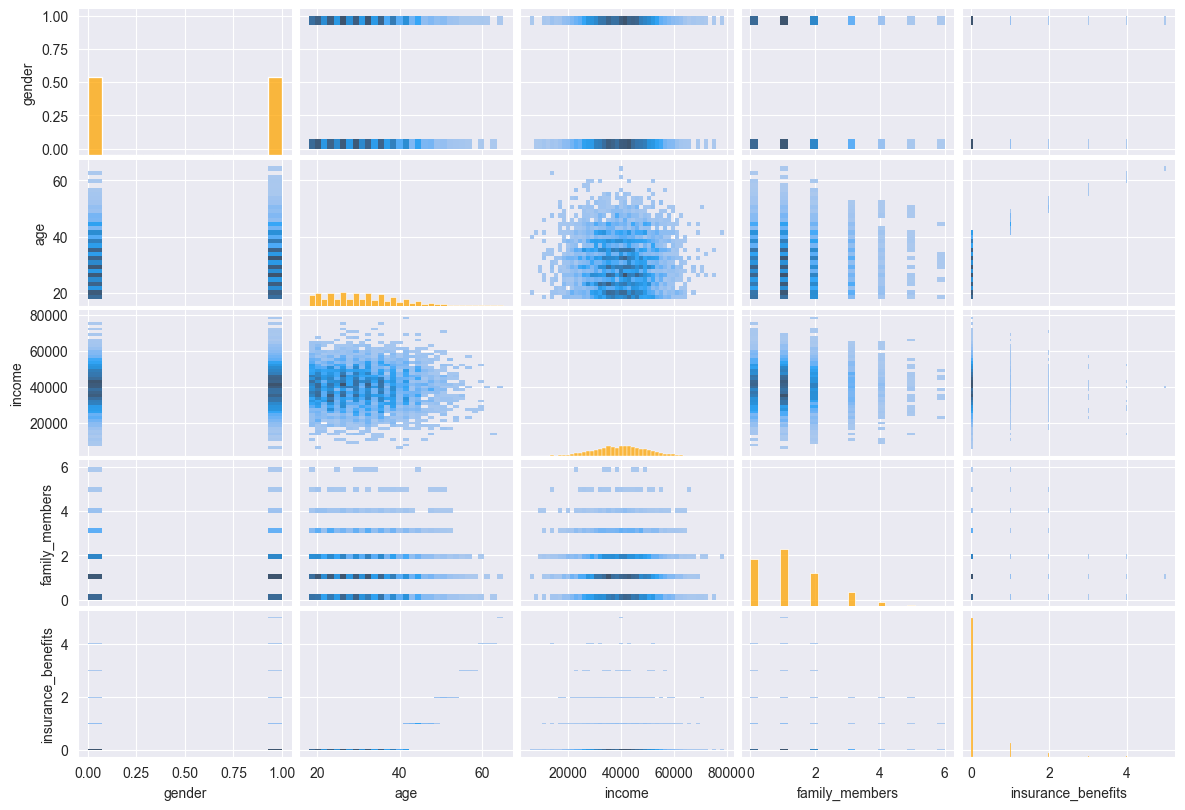

In [5]:
g = sns.pairplot(df, kind='hist',diag_kws={'color':'orange'})
g.fig.set_size_inches(12, 8)

**Nota:**

*Visualmente se denota la distribucion balanceada de la variable gender. Tambien podemos ver la tendencia de disminucion de usuarios segun la edad. (A mayor edad menos usuarios. `[La disminucion no parece extrema]`). Así mismo las familias en mayoria se conforman de 1 o 2 integrantes siendo menos comun aquellas de 3. Finalmente el plan `0` de beneficios es el dominante para este conjunto de datos.*

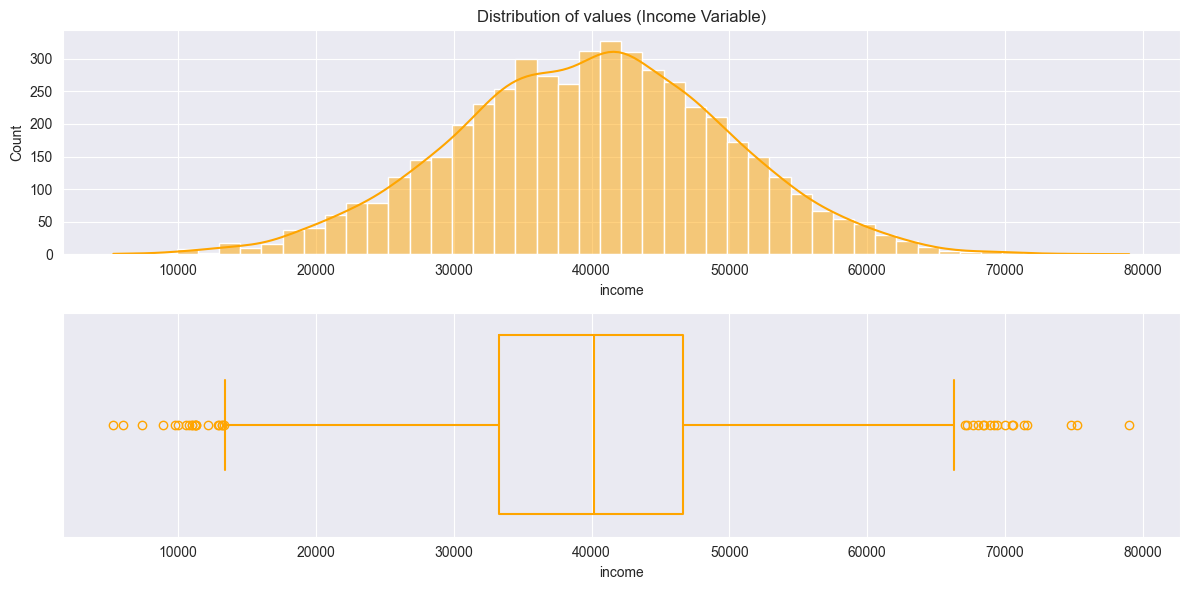

In [6]:
# Exploracion de la variable Income:
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.title('Distribution of values (Income Variable)')
sns.histplot(df, x='income', kde=True,color='orange')
plt.subplot(212)
sns.boxplot(df,x='income',orient='h',fill=0,color='orange')
plt.tight_layout()
plt.show()

**Nota:**

*Aparente distribucion normal para los valores de la variable `"income"`. Resaltan outliers en ambos extremos de los bigotes del Diagrama de caja. Sin embargo los outliers no debieran afectar la prediccion del modelo.*

# Clientes similares (Análisis de Clustering)

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.

TEMAS RELACIONADOS:
- Distancia entre vectores -> Distancia euclidiana / o distania Manhatan

Se escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada.

Se utiliza una implementación ya existente del algoritmo K-NN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)).

Probadó para tres casos
- Datos No Escalados
- Datos Escalados (Standard) [StandarScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
- Datos Escalados (MaxABS) [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)

¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?

In [7]:
def k_nn_function(data,n_neighbors:int,features:list | str,k=5,metric:str='euclidean'):
    """
    :param: data: DataFrame de pandas utilizado para encontrar objetos similiares dentro de sí mismo.
    :param: n_neighbors: Indice del objeto de interés
    :param: features: Columnas que pertenezcan a la matriz de caracteristicas.
    :param: k: Número de vecinos más cercanos a devolver.
    :param: metric: Nombre de la métrica de distancia (Scikit-Learn).
    """
    # Se crea la instancia para medir distancias entre observaciones
    model = NearestNeighbors(metric=metric)
    model.fit(data[features].values)

    # Extraemos tanto las distancias como los indices cercanos a la obserbacion deseada.
    distances, indexes = model.kneighbors([data.iloc[n_neighbors][features]],k + 1,return_distance=True)

    # Volvemos vector el array devuelto:
    distances = np.ravel(distances)
    indexes = np.ravel(indexes)

    # Filtramos el DataFrame original con los indices de los vecinos cercanos y agregamos la columna con las distancias.
    result = data.iloc[indexes].copy()
    result['distance'] = distances
    
    # Excluimos la observacion n_neighbor de los vecinos. (Siempre es el indice 0 porque siempre el vecino mas cercano a la observacion)
    # sera la observacion misma.
    query = result.iloc[0]
    answer = result.iloc[1:]

    return query, answer

# Con esta funcion podemos  evaluar vecinos cercanos para alguna observacion especifica del DataFrame. 
# Y asi mismo comparar que las categorias de la variable objetivo esten bien definidas en sus propios clusters.

## Para Clientes Similares Escalado de Datos

In [8]:
def escalate_data(data:pd.DataFrame, labels:list, kind:str = 'standard'):
    if kind == 'standard':
        scaler = StandardScaler()
        data[labels] = scaler.fit_transform(data[labels])
        return data, scaler
    if kind == 'max_abs':
        scaler = MaxAbsScaler()
        data[labels] = scaler.fit_transform(data[labels])
        return data, scaler

In [9]:
numeric_cols = ['age','income','family_members']
original = df.copy()
scalar_1, scaler_std = escalate_data(data=df.copy(),labels=numeric_cols,kind='standard')
scalar_2, scaler_max = escalate_data(data=df.copy(),labels=numeric_cols,kind='max_abs')

print('Data Sin Escalado')
display(original.head(1))
print('Data Escalado Standard')
display(scalar_1.head(1))
print('Data Escalado MaxABS')
display(scalar_2.head(1))

Data Sin Escalado


,gender,age,income,family_members,insurance_benefits
0,1,41,49600.0,1,0


Data Escalado Standard


,gender,age,income,family_members,insurance_benefits
0,1,1.190432,0.978235,-0.177957,0


Data Escalado MaxABS


,gender,age,income,family_members,insurance_benefits
0,1,0.630769,0.627848,0.166667,0


In [10]:
# Comprobacion de los vecinos cercanos:
usuario = 4500
features_columns = ['gender','age','income','family_members']
target_column = ['insurance_benefits']

q1, a1 = k_nn_function(data=original.copy(),n_neighbors=usuario,features=features_columns)
q2, a2 = k_nn_function(data=scalar_1.copy(),n_neighbors=usuario,features=features_columns)
q3, a3 = k_nn_function(data=scalar_2.copy(),n_neighbors=usuario,features=features_columns)

print('Plan de Beneficio Real')
display(pd.DataFrame(data=q1[target_column].values.astype(int),columns=['insurance_benefits'],index=['usuario {}'.format(usuario)]))
# Quitar .head(1) para ver las coincidencias completas
print()
print('Vecinos Datos Sin Escalar')
display(a1.head(2))
print()
print('Vecinos Escalado Standard')
display(a2.head(2))
print()
print('Vecinos Escalado MaxABS')
display(a3.head(2))

Plan de Beneficio Real


,insurance_benefits
usuario 4500,0



Vecinos Datos Sin Escalar


,gender,age,income,family_members,insurance_benefits,distance
403,0,32,58900.0,2,0,4.242641
2894,0,22,58900.0,4,0,14.352700



Vecinos Escalado Standard


,gender,age,income,family_members,insurance_benefits,distance
2768,1,0.598012,1.766186,-0.177957,0,0.151529
3034,1,0.361044,1.958123,-0.177957,0,0.240388



Vecinos Escalado MaxABS


,gender,age,income,family_members,insurance_benefits,distance
2768,1,0.553846,0.726582,0.166667,0,0.018987
4904,1,0.553846,0.715190,0.166667,0,0.030380


In [11]:
def check_integrity(data, features, target, k=5):
    """ Calcular porcentaje de similitud """
    model = NearestNeighbors(n_neighbors=k+1).fit(data[features])
    distances, indices = model.kneighbors(data[features])
    
    # Obtenemos las etiquetas de los vecinos (saltando la primera que es el punto mismo)
    neighbor_labels = data[target].values[indices[:, 1:]]
    actual_labels = data[target].values.reshape(-1, 1)
    
    # Comparamos cuántos vecinos coinciden con la etiqueta real
    matches = (neighbor_labels == actual_labels).sum(axis=1)
    return matches.mean() / k  # Devuelve un porcentaje de 0 a 1

# Comparación rápida
print(f"Integridad (Sin Escalar): {check_integrity(df.copy(), numeric_cols, 'insurance_benefits'):.2%}")
print(f"Integridad (Standard): {check_integrity(scalar_1.copy(), numeric_cols, 'insurance_benefits'):.2%}")
print(f"Integridad (MaxABS): {check_integrity(scalar_2.copy(), numeric_cols, 'insurance_benefits'):.2%}")

Integridad (Sin Escalar): 87.96%
Integridad (Standard): 97.30%
Integridad (MaxABS): 97.34%


**Nota Final de Esta Seccion:**

*Los vecinos obtenidos (validacion de cluster) si se ve afectada por el escalado de datos. La mejor precision se alcanzo de MaxAbsScaler 97.34% (lo cual hace sentido dado que hay outliers extremos en las columnas `["income" "age"]` afecando ligeramente a StandardScaler). Por su parte StandardScaler alcanzo una fidelidad de 97.30%. Con esta informacion se pudo validar como el plan de beneficio para cada usuario esta apropiadamente categorizado, la validacion de cluster (tipos de plan de beneficio) fue positiva. Para $n^{th}$ observacion se obtuvo un plan de beneficio similar.* 

# Balance de Clases y Probabilidad de obtencion de Seguro

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Utilizando la columna `insurance_benefits` como punto de partida se crea la variable objetivo.

Metodología: Clasificación y Evaluación de Modelos:

En esta fase del proyecto, el objetivo central es determinar la eficacia de un modelo predictivo para identificar clientes que recibirán beneficios de seguro. El proceso se fundamenta en la comparación de dos enfoques: El algoritmo de K-Vecinos Cercanos (KNN) y un modelo de referencia (Dummy).

1. Implementación y Optimización del Clasificador KNNSe utiliza el algoritmo KNeighborsClassifier para realizar una clasificación binaria. El experimento se diseña para analizar dos factores críticos que afectan el rendimiento:
2. Influencia del Hiperparámetro $k$: Se evalúa la métrica F1 iterando con valores de $k$ en un rango de 1 a 10. Esto permite observar cómo la cantidad de vecinos consultados afecta la capacidad de generalización del modelo.
3. Impacto del Escalamiento de Datos: Se comparan los resultados obtenidos con los datos originales frente a los datos procesados con escaladores técnicos. Dado que KNN se basa en medidas de distancia, esta comparativa revela si las magnitudes de variables como income o age distorsionan la clasificación.
4. Establecimiento del Baseline (Modelo Dummy)Para contextualizar el éxito del modelo KNN, se desarrolla un clasificador aleatorio o dummy. Este sirve como punto de referencia para asegurar que las predicciones del modelo principal sean producto del aprendizaje y no del azar. La evaluación del modelo dummy se realiza bajo cuatro umbrales de probabilidad ($P$):$P = 0$: El modelo nunca predice un beneficio. $P = 1$: El modelo siempre predice la obtención del seguro. $P = 0.5$: Una predicción puramente aleatoria (moneda al aire). $P = \text{Probabilidad Real}$: Basada en la frecuencia histórica del conjunto de datos, calculada como el cociente entre los clientes con beneficios y el total de la muestra: $$P\{\text{prestación de seguro}\} = \frac{\text{clientes con beneficio}}{\text{total de clientes}}$$
5. Protocolo de ValidaciónPara garantizar la integridad de los resultados y evitar el sobreajuste (overfitting), la totalidad de los datos se divide en conjuntos de entrenamiento y prueba, siguiendo una proporción de 70:30. Este enfoque permite validar el comportamiento de los algoritmos ante datos que no han sido vistos durante el proceso de ajuste inicial.

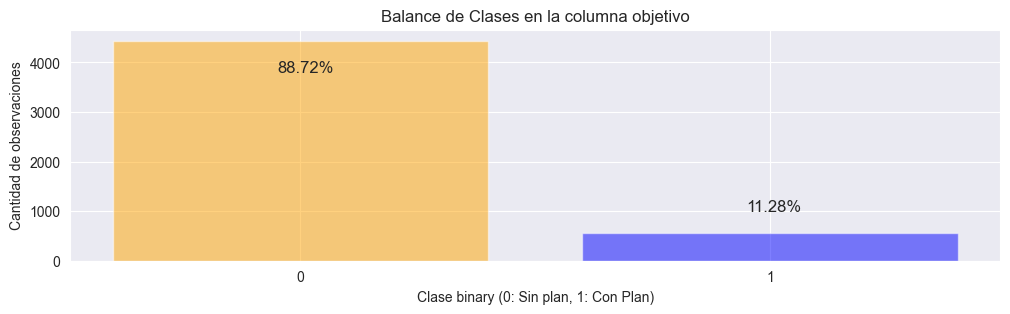

,Sin Seguro,Con Seguro,Probabilidad de Seguro
Total,4436,564,11.28 %


A continuacion la correlacion de las caracteristicas con respecto al valor objetivo
target                1.000000
insurance_benefits    0.896207
age                   0.658631
gender               -0.001816
income               -0.002378
family_members       -0.029852
Name: target, dtype: float64


In [15]:
# Samos que hay distintos tipos de planes de seguro en la columna "insurance_benefits".
# Podriamos construir un modelo multi-clasificador para las distintas clases (seguros).
# Sin embargo solo la empresa unicamente quiere saber quienes pueden obtener un seguro independiente del tipo y quienes no.
# Esto hace esta tarea una clasificacion binaria.

# 1. A partir de la columna "insurance_benefits" crear la columna objetivo. 
df['target'] = df['insurance_benefits'].apply(lambda x: 1 if x > 0 else 0)
balance = df['target'].value_counts(normalize=True)
balance = np.ravel(balance)

# 2. Observamos la distribucion de clases:
plt.figure(figsize=(12,3))
plt.bar(data=df,x=df['target'].unique(),height=df['target'].value_counts(),color=['orange','blue'],alpha=0.5)
plt.xticks([0,1])
x = 0
y = 3800
for i in balance:
    plt.annotate(text=f'{i* 100}%',xy=(x - 0.05,y),fontsize=12)
    x += 1
    y -= 2800
plt.title('Balance de Clases en la columna objetivo')
plt.ylabel('Cantidad de observaciones')
plt.xlabel('Clase binary (0: Sin plan, 1: Con Plan)')
plt.show()

probabilidad = [str((df['target'].value_counts().values[1].astype(int) / df.shape[0]) * 100) + ' %']
totales = df['target'].value_counts().values.tolist()
totales = totales + probabilidad

display(pd.DataFrame(data=[totales],index=['Total'],columns=['Sin Seguro','Con Seguro','Probabilidad de Seguro']))
print('A continuacion la correlacion de las caracteristicas con respecto al valor objetivo')
print(df.corr()['target'].sort_values(ascending=False))

**Nota:**

La probabilidad de obtencion de un seguro es de:
$$ P = \frac {Usuarios Con Seguro} {Usuarios Totales} $$
La probabilidad de obtencion de seguro es nuestro balance de clases con respecto al total. En este caso estamos en el umbral del 10% de observaciones positivas para un modelo de clasificacion. Esto es comun en este tipo de modelo, por tanto debemos asegurarnos de especificar `'balanced'` para el hiperparametro `class_weight` al momento de entrenar los modelos. (El `sobremuestreo` es otra opcion para tratar el desbalance de clases).

# Metricas de Evaluacion

In [13]:
def evaluation(true_values, predictions, name:str='this Evaluation', c_palette:str='Blues'):
    score_f1 = f1_score(y_true=true_values,y_pred=predictions)
    score_precision = precision_score(y_true=true_values,y_pred=predictions,zero_division=0)
    score_recall = recall_score(y_true=true_values,y_pred=predictions)
    cm = confusion_matrix(y_true=true_values,y_pred=predictions)

    results = pd.DataFrame(
        data=[[score_f1,score_precision,score_recall]],
        columns=['F1','Precision','Recall'])
    data = pd.DataFrame(data=cm,index=['Sin Seguro (0)','Con Seguro (1)'],columns=['Sin Seguro (0)','Con Seguro (1)'])

    plt.figure(figsize=(8,3))
    sns.heatmap(data=data,annot=True,fmt='d',cmap=c_palette,cbar=False,linewidths=1,annot_kws={'fontsize':14}) 
    # cbar para mostrar o no mostrar la barra lateral de escala, fmt= ajusta a formato numerico simple
    plt.title(f'Confussion Matrix {name}')
    plt.ylabel('Real')
    plt.xlabel('Prediccion')
    plt.show()

    display(results.style.format("{:.2%}"))

# Procesamiento de datos

In [14]:
# Particion de datos: (Se ocupa stratify para mantener la proporcion de clases en Y, aprox 11.28)
X = df.drop(labels=['insurance_benefits','target'],axis=1)
Y = df['target']

x_train, x_test, y_train, y_test = train_test_split(X,Y,random_state=SEED,test_size=0.3,shuffle=True,stratify=Y)

# Copias de las matrices X con el escalado:
x_train = x_train.copy()
x_test = x_test.copy()

# Copias de las matrices X sin el escalado:
x_train_raw = x_train.copy()
x_test_raw = x_test.copy()

# Escalamos los datos, utilizando aquel con el mayor puntaje de validacion de cluster 97.34% MaxAbsScaler():
scaler = MaxAbsScaler()
x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

display(x_train_raw.head(1))
display(x_train.head(1))
display(x_test_raw.head(1))
display(x_test.head(1))

,gender,age,income,family_members
164,1,22,43300.0,1


,gender,age,income,family_members
164,1,0.338462,0.578877,0.166667


,gender,age,income,family_members
1843,1,23,28500.0,2


,gender,age,income,family_members
1843,1,0.353846,0.381016,0.333333


# Modelo Dummy: Con umbral de probabilidad de prediccion:

**Nota** 

La misma funcion que se implementa en el siguiente bloque de codigo se pude obtener de una manera mas sencilla con `DummyClassifier` de scikit-learn. Ocupar el parametro `stratified` para mantener el balance de clases. Sin embargo de esta manera se puede ver mejor la logica de construccion de un `dummy-classifier`.

LA PROBABILIDAD: 0.00%


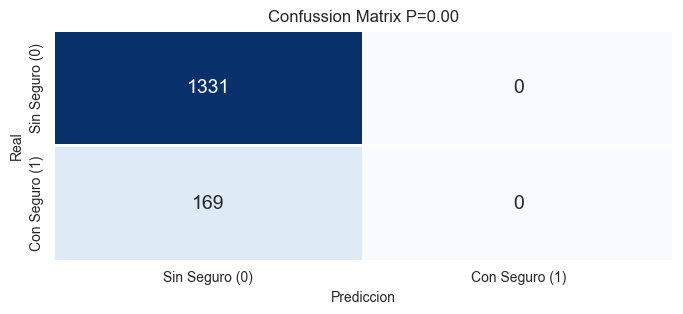

,F1,Precision,Recall
0,0.00%,0.00%,0.00%


*************************************************************************************
LA PROBABILIDAD: 11.29%


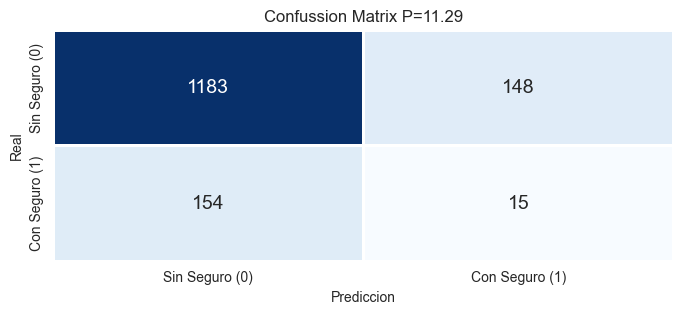

,F1,Precision,Recall
0,9.04%,9.20%,8.88%


*************************************************************************************
LA PROBABILIDAD: 50.00%


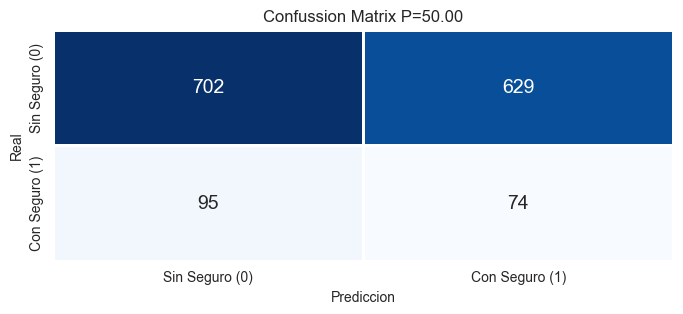

,F1,Precision,Recall
0,16.97%,10.53%,43.79%


*************************************************************************************
LA PROBABILIDAD: 100.00%


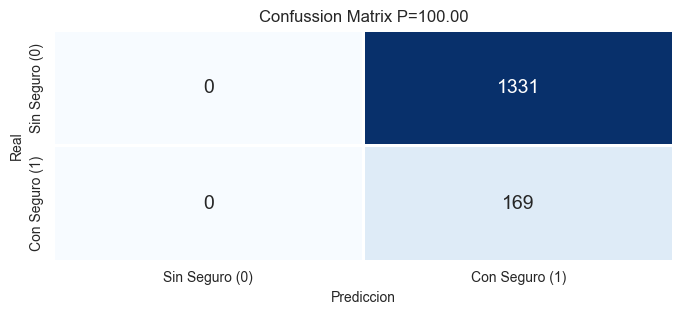

,F1,Precision,Recall
0,20.25%,11.27%,100.00%


*************************************************************************************


In [15]:
# Generar la salida de un modelo aleatorio
def rnd_model_predict(P, size, seed=SEED):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

# Probabilidades a evaluar: [0%, real=(np.sum(y_train) / y_train.shape[0]), 50%, 100%]
for P in [0, np.sum(y_train) / y_train.shape[0], 0.5, 1]:

    print(f'LA PROBABILIDAD: {(P*100):.2f}%')
    random_prediction = rnd_model_predict(P=P,size=x_test.shape[0])
        
    evaluation(true_values=y_test,predictions=random_prediction,name=f"P={(P*100):.2f}")
    
    print('*'*85)

**Nota:**

Se puede ver que el dummy-classifier predice bien usando el umbral 11.28 de probabilidad de asignacion de seguro. Sin embargo ahora mediante el machine learning veremos si podemos superar ese comportamiento de error.

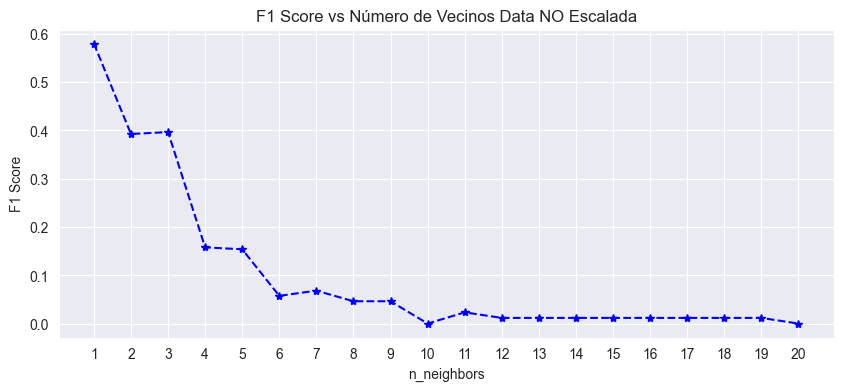


**************************************************************************************************************


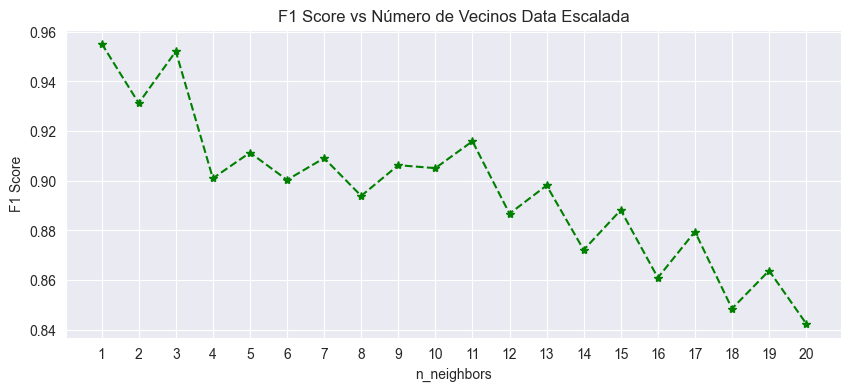

In [16]:
# (KNeighborsClassifier) Determinaremos con que valor de vecinos el modelo clasifica mejor (Funcion):
def knn_evaluation_plot(x_train, y_train, x_test, y_test, title,color='blue'):
    f1_scores = []
    neighbors = range(1, 21) # Ampliamos el rango para ver la curva
    
    for n in neighbors:
        model = KNeighborsClassifier(n_neighbors=n)
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        f1_scores.append(f1_score(y_test, pred))
    
    plt.figure(figsize=(10, 4))
    plt.plot(neighbors, f1_scores, marker='*', linestyle='--', color=color)
    plt.title(f'F1 Score vs Número de Vecinos {title}')
    plt.xlabel('n_neighbors')
    plt.ylabel('F1 Score')
    plt.xticks(neighbors)
    plt.grid(True)
    plt.show()

# Comparacion ambos:
knn_evaluation_plot(x_train_raw, y_train, x_test_raw, y_test, title='Data NO Escalada')
print()
print('*'*110)
knn_evaluation_plot(x_train, y_train, x_test, y_test, title='Data Escalada',color='green')

# MODELO DE CLASIFICACION (KNeighborsClassifier)

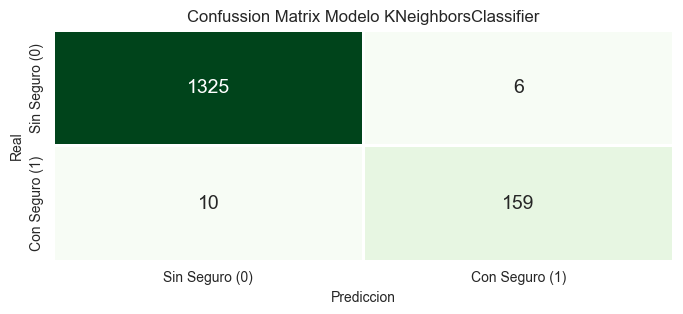

,F1,Precision,Recall
0,95.21%,96.36%,94.08%


In [17]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(x_train,y_train)
prediction = model.predict(x_test)
evaluation(true_values=y_test, predictions=prediction, name='Modelo KNeighborsClassifier', c_palette='Greens')

# Regresión (Algoritmo de Regresion Lineal)

Con `insurance_benefits` como objetivo, se evalua un modelo de regresion lineal. Ademas de que se mostrara la logica de este algoritmo siguiendo la formula a continuacion.

Denotemos
- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades
- $y$ — objetivo (un vector)
- $\hat{y}$ — objetivo estimado (un vector)
- $w$ — vector de pesos

La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:

$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ que minimice la distancia (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:

$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos

$$
\hat{y} = X_{val}w
$$

In [18]:
# Modelo de Regresion Lineal (Algoritmo)
class RegressionLinealAlgorithm():
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # Agregar columna de unidades en la matriz X del conjunto de entrenamiento
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        # Con la formula para determinar w, se calculan los pesos para la regresion lineal
        self.weights = ((np.linalg.inv(X2.T@X2))@(X2.T))@y
        # Esta manera de calcular pesos es ineficiente con conjuntos mayores, por eso se opta por el descenso de gradiente.

    def predict(self, X):
        
        # Agregar columna de unidades en la matriz X del conjunto de preba
        X2 = np.append(np.ones([len(X),1]),X,axis=1)
        # Conociendo los pesos podemos usarlos para la prediccion
        Y = X2.dot(self.weights)
        
        return Y

In [19]:
# Funcion para evaluar Metrica (RMSE) (MAE)
def eval_regressor(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true=y_true,y_pred=y_pred))
    mae = mean_absolute_error(y_true=y_true,y_pred=y_pred)
    r2 = r2_score(y_true=y_true,y_pred=y_pred)
    data = pd.DataFrame(data={'rmse':[rmse],'mae':[mae],'r2':[r2]},index=['results'])

    display(data.style.format("{:.2%}"))

In [20]:
# Probando el algoritmo de regresion lineal en datos NO escalados y Escalados:
lr_1 = RegressionLinealAlgorithm()
lr_1.fit(x_train_raw,y_train)
prediction = lr_1.predict(x_test_raw)
eval_regressor(y_test,prediction)
print('RegresionLineal SIN Datos Escalados')
print()
print('*'*85)
print()

lr_2 = RegressionLinealAlgorithm()
lr_2.fit(x_train,y_train)
prediction = lr_2.predict(x_test)
print('RegresionLineal Con Datos Escalados')
eval_regressor(y_test,prediction)

,rmse,mae,r2
results,23.89%,18.70%,42.92%


RegresionLineal SIN Datos Escalados

*************************************************************************************

RegresionLineal Con Datos Escalados


,rmse,mae,r2
results,23.89%,18.70%,42.92%


**Nota Importante:**

El algoritmo de RegresionLineal no cambiara su ajuste para la prediccion aunque se escalen los datos. Esto pasa porque a pesar de que los pesos $w$ cambian al pasar diferentes formatos para la matriz de $X$, mientras sean los mismos datos aquellos en crudo y escalados, la linea que se crea para representar la prediccion se ajustare al minimo posible para ambos casos y siendo estos los mismos la prediccion y por ende el puntaje de salida seran los mismos.

# Ofuscar Datos

Lo mejor es ofuscar los datos multiplicando las `características numéricas` (la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Por cierto, la propiedad de invertibilidad es importante aquí, así que siempre asegúrate de que $P$ sea realmente invertible.

Importante la familiaridad con (operaciones de matrices) y (Numpy)

In [21]:
extracto = ['gender','age','income','family_members']
data = df[extracto]
print('Data Original')
display(data.head(2))
# Creamos la matriz X que sera ofuscada:
X = data.to_numpy()

# Creacion de matriz aleatoria de dimensiones (columnas . columnas) de X para la ofuscacion, nombrada P.
rng = np.random.default_rng(seed=SEED)
P = rng.random(size=(X.shape[1],X.shape[1]))

# Comprobamos que P sea una matriz invertible:
IP = np.linalg.inv(P)
print()
print('Matriz de Ofuscacion Invertida')
print(IP[:2])

# Ofuscamos los datos en la matriz original X, resltado OX con valores irreconosibles.
OX = X@P
print()
print('Matrix X Ofuscada')
display(pd.DataFrame(data=OX,columns=extracto).head(2))

Data Original


,gender,age,income,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1



Matriz de Ofuscacion Invertida
[[-1.97240014  1.76004024 -0.08309671  1.22285233]
 [ 0.14111106  0.32873452  1.02824721 -1.27752175]]

Matrix X Ofuscada


,gender,age,income,family_members
0,33385.629848,46727.480145,12338.757310,47073.723967
1,25583.387949,35803.914219,9461.301198,36066.960022


¿Puedes recuperar los datos originales de $X'$ si conoces $P$? En este caso las reglas de la multiplicación matricial son realmente útiles.

- **Respuesta:** Si se puede. Solo debemos despejar $X$ para la operacion realizada previamente:

Mucho cuidado, en algebra lineal, el orden de los factores si altera el producto, si queremos despejar $X$, y el valor que alteramos esta a la derecha de $X$, como es este caso, entonces $P^{-1}$ debera estar a la derecha de X en ambos lados de la igualdad. 
$$ X' = XP$$
$$ X'P^{-1} = X(PP^{-1}) $$
$$ X'P^{-1} = XI $$
Cualquier producto punto de una matriz identidad $I$ por otra cualquiera da como resultado la misma matriz:
$$ X = X'P^{-1}$$

*Hemos recuperado X original, sin embargo se ven numero distintos en el DataFrame recuperado, si notamos los decimales veremos que la diferencia es tan pequenha que son practicamente el mismo numero, esto pasa porque hemos cambiado los datos de tipo a los array de numpy. Pero con `allclose()`, hemos verificado que ambos DataFrames $X$ y $RX$ son el mismo*. `Observar siguiente bloque de codigo:`

In [22]:
print('Aqui la matrix X original:')
RX = OX@IP
display(pd.DataFrame(data=RX,columns=extracto).head(2))
print()
print('Por Ultimo, utilizando np.allclose podemos verificar que son la misma matriz:')
print()
print(np.allclose(X,RX))

Aqui la matrix X original:


,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.0
1,6.711644e-13,46.0,38000.0,1.0



Por Ultimo, utilizando np.allclose podemos verificar que son la misma matriz:

True


# Prueba de que la ofuscación de datos puede funcionar con regresión lineal

Demostración _analytically_ de que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?

Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

Respuesta
---


Los valores predichos para los pesos debieran ser los mismos para datos fuscados y no ofuscados.
Por tanto los valores predichos debieran ser iguales en ambos casos y de igual manera los resultados obtenidos por RECM

**Prueba analítica:**

Formulas iniciales
$$
w = (X^TX)^{-1}X^Ty \quad \Rightarrow \quad w_p = [(XP)^T XP]^{-1} (XP)^T y
$$
Reversibilidad de transposicion de un producto de matrices: </td><td>$(AB)^T = B^TA^T$</td>
$$ 
w_p = (P^TX^TXP)^{-1}P^T X^Ty
$$
Propiedad de la inversa de un producto: $(AB)^{-1} = B^{-1}A^{-1}$.
`Para:` $(X^TX)$ `(X es la matriz de caracteristicas la cual no es comun que sea cuadrada, por tanto no tiene inversa sino hasta obtener su producto). La notacion correcta seria dejarla como la matriz inversa del producto punto de X por X transpuesta:` $(X^TX)^{-1}$
$$
w_p = P^{-1} (X^TX)^{-1} (P^T)^{-1} P^T X^T y
$$
Como: $ (P^T)^{-1} P^T = I $ La identidad entonces:
$$
w_p = P^{-1} (X^TX)^{-1} I X^T y
$$
Y como: $ I X^T = X^T $ entonces tenemos:
$$
w_p = P^{-1} \underbrace{(X^TX)^{-1} X^T y}_{w}
$$
Finalmente la relacion esta en que:
$$
w_p = P^{-1} w
$$

- ¿Cuáles serían los valores predichos con $w_P$? Si los valores predichos son $\hat{y} = Xw$ para los datos originales, para los datos ofuscados serán $\hat {y}_p = (XP)w_p$.

Sustituyendo resultado:$$\hat{y}_p = (XP)(P^{-1}w)$$$$\hat {y}_p = X(PP^{-1})w = X I w = Xw = \hat {y}$$Conclusión: Los valores predichos son exactamente los mismos: $$\hat{y}_p = \hat{y}$$

- ¿Qué significa para la calidad (RECM)?Dado que el Error Cuadrático Medio (o RECM) depende únicamente de la diferencia entre el valor real $y$ y el valor predicho $\hat{y}$, y como acabamos de demostrar que $\hat{y} = \hat{y}_p$, el error será idéntico en ambos modelos. La calidad de la regresión no se degrada.

## Prueba de regresión lineal con ofuscación de datos

**Procedimiento**

- Se crea una matriz cuadrada $P$ de números aleatorios.
- Se comprueba que sea invertible. Si no lo es, se repite el primer paso hasta obtener una matriz invertible.
- <¡No hay diferencia ambos procedimientos dan los mismos resultados tanto en la metrica RMSE como en $R^{2}$!>
- Se utiliza $XP$ dentro del algoritmo de regresion lineal como la nueva matriz de características.

In [23]:
# Creacion de un modelo de regresion lineal ofuscado:
class MyLinearRegression2:
        
    def __init__(self):
        self.weights=None
        self.weights_p = None
        self.P = None
        
    def fit(self, X, y,tipo=None):
        
        if tipo == 'ofuscar':
            
            rng = np.random.default_rng(seed=42)
            self.P = rng.random(size=(X.shape[1], X.shape[1]))
            XP = X.dot(self.P)
            XP = np.append(np.ones([len(XP),1]),XP,axis=1)
            self.weights_p = ((np.linalg.inv(XP.T@XP))@XP.T).dot(y)
        
        X_extended = np.append(np.ones([len(X),1]),X,axis=1)
        self.weights = ((np.linalg.inv(X_extended.T@X_extended))@(X_extended.T))@y
        
    def predict(self, X,tipo=None):
        if tipo == 'ofuscar':
            XP = X.dot(self.P)
            XP = np.append(np.ones([len(XP),1]),XP,axis=1)
            y_pred = XP.dot(self.weights_p)
            
            return y_pred
        else:
            X_extended = np.append(np.ones([len(X),1]),X,axis=1)
            y_pred = X_extended.dot(self.weights)

            return y_pred


In [24]:
# Prueba ofuscada
lr = MyLinearRegression2()

lr.fit(x_train, y_train, tipo='ofuscar')
print('Pesos al ofuscar')
print(lr.weights_p)

prediction = lr.predict(x_test, tipo='ofuscar')
eval_regressor(y_test, prediction)

Pesos al ofuscar
[-0.64985984 -2.34302394  0.67226557  2.58610433 -1.01646396]


,rmse,mae,r2
results,23.89%,18.70%,42.92%


In [25]:
# Prueba no ofuscada
lr = MyLinearRegression2()

lr.fit(x_train, y_train)
print('Pesos sin ofuscar')
print(lr.weights)

prediction = lr.predict(x_test)
eval_regressor(y_test, prediction)

Pesos sin ofuscar
[-0.64985984 -0.00678036  1.60459817  0.01950481 -0.03974168]


,rmse,mae,r2
results,23.89%,18.70%,42.92%


# Conclusiones

**Validacion de Clusters, Clasificacion binaria, KNeighborsClassifier**
1. Hemos demostrado como la categorizacion de nuestra columna "insurance_benefits" sigue una logica de vecindad, haciendo que los grupos esten delimitados adecuadamente, esto permitio buscar vecinos cercanos con distintas entradas $n^{th}$ y obtener observaciones similares.
2. Se pudo superar los modelos dummies para distintos umbrales de manera eficiente, se entreno un modelo con: F1 `95.21%`	Precision `96.36%`	Recall `94.08%`. Esto permite que la aseguradora pueda detectar de manera eficiente aquellos usuario posibles de ser asegurados.

**Regresion Lineal, Algebra Lineal, Ofuscacion**
1. La regresion lineal se puede hacer con o sin ofuscacion, se obtendran los mismos resultados gracias a la relacion $w_p = P^{-1}w$. Notar que fue el mismo caso para datos escalados y no escalados. Todos obtuvieron el mismo puntaje RMSE: `23.89%`.
2. La ofuscacion permite enmascarar los datos, la unica manera de conocer las variables adecuadamente seria conociendo $P^{-1}$
3. El escalado de datos es fundamental para aumentar el puntaje de los modelos, especialmente para K-NN

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>

In [26]:
# Exportando modelo ganador:
import joblib
import json

joblib.dump(model,'KNeighborsClassifier.joblib',compress=3)
joblib.dump(scaler,'scaler.joblib')

with open('metadata.json','w',encoding='utf-8') as f:
    json.dump(
        {
            'n_neighbors': 3,
        },
    f,
    indent=2,
    ensure_ascii=False
    )

x_test.to_pickle('x_test.pkl')
y_test.to_pickle('y_test.pkl')